In [204]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
import gdal
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  

# hand made functions
from Rouss1 import gp2idomain, gp2cellids, get_heads, get_spdis, get_MNTbbox, import_riv
from Rouss1 import inter_lst,get_cellcenters, lin_interp

In [205]:
model_dir = "working"
model_name = "first_2D"
exe_name= "../../exe/mf6"

In [206]:
R_path="../data/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
MNT_path= "../data/MNT/MNT_50.tif"
Agly_path= "../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path= "../data/Fleuves/Tet_ludo.shp"
Rea_path = "../data/Fleuves/Reart_ludo.shp"
Tech_path = "../data/Fleuves/Tech_ludo.shp"


In [207]:
#spatial parameters

# get x0,y0,y1 and x1 from the DEM
x0,y0,x1,y1 = get_MNTbbox(MNT_path)
x1 += 4000

Lx = x1-x0
Ly = y1-y0
nlay = 1
ncol = nrow = 100
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(nrow)*(Ly/nrow)
botm = -100
top = 10. # if no mnt is provided
idomain = np.zeros((nrow*ncol))

In [208]:
# load top data
MNT = Raster.load(MNT_path)
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0)

top = MNT.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = MNT.bands[0],
                                method="nearest")

In [209]:
R = gp.read_file(R_path) # import shapefile with geopandas

#cells inside the aquifer become active and return the lst of the cellids
lst_domain = gp2idomain(R,grid,idomain,area=0) # all the cells of the model


In [210]:
# recharge areas
rcha=[]
rch_areas = Raster.load("../data/recharge/rast_peff.tif")
rcha = rch_areas.resample_to_grid(grid.xcellcenters,
                            grid.ycellcenters,
                            band = rch_areas.bands[0],
                            method="nearest")

rcha[rcha==0]=np.mean(rcha[rcha!=0])
coeff = 0.5 # part de pluie qui s'infiltre
rcha *= coeff

In [211]:
### BC sea

# import the shapefile that correspond to the BC
BCsea_path = "../data/Sea_BC_L93.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids(grid,BC_sea,idomain,type="line")

# attribute a constant head at all the cells in the lst_chd
CHD = 0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [212]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids(grid,etangs.dissolve(by="NATURE"),idomain,areas=10)

# attribute a constant head
CHD = 0; et_chd_lst=[];
for x in etangs_chd:
    et_chd_lst.append((x,CHD))


In [213]:
def linInt_Dfcol(df,col="head",null=0):
    
    """
    function that linearly interpolates the values in a column btwn certain given value a null value is indicated by 0.
    this function needs the lin_interp function.
    """
    
    new_heads=np.zeros([df.shape[0]])
    for i in np.arange(df[df[col]!=0].index.shape[0]-1):
        idx1 = df[df[col]!=0].index[i]
        idx2 = df[df[col]!=0].index[i+1]
        new_heads[idx1:idx2+1] = lin_interp(df.lengths[idx1:idx2+1],df[col][idx1],df[col][idx2])
        
    df[col]=new_heads

In [214]:
# BC Agly
BC_Agly = gp.read_file(Agly_path) # read shp, linestring from ups to dws
df_agy = import_riv(grid,BC_Agly) # extract cellids intersected + lengths in each cells
df_agy["xc"],df_agy["yc"] = get_cellcenters(grid,df_agy.cellids)
df_agy["head"] = np.zeros([df_agy.shape[0]])

# station(s) and assignement of heads
xs = 691850.9; ys = 6185873.7; elev = 11.39
dist = ((df_agy["xc"] - xs)**2 + (df_agy["yc"] - ys)**2)**0.5
df_agy["head"][dist==np.min(dist)] = elev + 1

# us and ds heads
df_agy["head"].iloc[0] = 28
df_agy["head"].iloc[-1] = 0.1

# interpolation of the heads btw ups,stations and ds
linInt_Dfcol(df_agy,col="head")

#drop cellids which are already constant head
a = inter_lst(df_agy.cellids, lst_chd)
for i in range (len(a)):
    df_agy = df_agy.drop(df_agy[df_agy["cellids"] == a[i]].index)

# create the stress package
H_riv = df_agy["head"]
Agy_chd=[]; o =-1;
for x in df_agy.cellids:
    o = o + 1
    Agy_chd.append((x,H_riv[o]))

C:\Users\emmal\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\emmal\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\emmal\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [215]:
## BC Tet
gp_Tet = gp.read_file(Tet_path)
df_tet = import_riv(grid,gp_Tet)  
df_tet["xc"],df_tet["yc"] = get_cellcenters(grid,df_tet.cellids)
df_tet["head"] = np.zeros([df_tet.shape[0]])

# us and ds heads
df_tet["head"].iloc[-1] = 0.1

#add the head of the stations
Tet_stations=pd.read_csv("../data/stations_tet.csv",sep=";") # import the stations in a df
for i in Tet_stations.index: # attribute a head value to the closest point of the the station
    xs = Tet_stations.loc[i].x
    ys = Tet_stations.loc[i].y
    elev = Tet_stations.loc[i].elev
    dist = ((df_tet["xc"] - xs)**2 + (df_tet["yc"] - ys)**2)**0.5
    df_tet["head"][dist==np.min(dist)] = elev + 1

# interpolation of the heads btw ups,stations and ds
linInt_Dfcol(df_tet,col="head")

#drop cellids which are already constant heads
for cellid in df_tet.cellids:
    if cellid in lst_chd:
        df_tet = df_tet.drop(df_tet[df_tet["cellids"] == cellid].index)
    if cellid not in lst_domain:
        df_tet = df_tet.drop(df_tet[df_tet["cellids"]== cellid].index)

df_tet = df_tet.reset_index()
H_riv = df_tet["head"]
# create the stress package
Tet_chd=[]; o =-1;
for x in df_tet.cellids:
    o = o + 1
    Tet_chd.append((x,H_riv[o]))

C:\Users\emmal\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


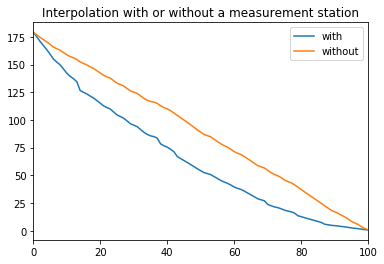

In [216]:
df_tet["head"].plot(label="with")
plt.plot(lin_interp(df_tet.lengths,180,0),label="without")
plt.title("Interpolation with or without a measurement station")
plt.legend()

In [217]:
## BC Reart
gp_riv = gp.read_file(Rea_path)
df_riv = import_riv(grid,gp_riv) # extract cellids from the river, in order with associated lengths   


# assign heads along the river
df_riv["head"] = lin_interp(df_riv.lengths,100,-10)

# drop some cells
for cellid in df_riv.cellids:
    if (cellid in lst_chd) | (cellid in etangs_chd):
        df_riv = df_riv.drop(df_riv[df_riv["cellids"] == cellid].index)
    if cellid not in lst_domain:
        df_riv = df_riv.drop(df_riv[df_riv["cellids"]== cellid].index)


df_riv= df_riv.reset_index()
H_riv = df_riv["head"]
# create the stress package
Rea_chd=[]; o =-1;
for x in df_riv.cellids:
    o = o + 1
    Rea_chd.append((x,H_riv[o]))

In [218]:
#BC Tech
gp_riv = gp.read_file(Tech_path)
df_riv = import_riv(grid,gp_riv) # extract cellids from the river, in order with associated lengths   
df_riv["xc"],df_riv["yc"] = get_cellcenters(grid,df_riv.cellids)
df_riv["head"] = np.zeros([df_riv.shape[0]])

# ds heads
df_riv["head"].iloc[-1] = 0.1

#add the head of the stations
Tech_stations=pd.read_csv("../data/stations_tech.csv",sep=";") # import the stations in a df
for i in Tech_stations.index: # attribute a head value to the closest point of the the station
    xs = Tech_stations.loc[i].x
    ys = Tech_stations.loc[i].y
    elev = Tech_stations.loc[i].elev
    dist = ((df_riv["xc"] - xs)**2 + (df_riv["yc"] - ys)**2)**0.5
    df_riv["head"][dist==np.min(dist)] = elev + 1 #issue warning ? but works

# interpolation of the heads btw ups,stations and ds
linInt_Dfcol(df_riv,col="head")

# assign heads along the river
# df_riv["head"] = lin_interp(df_riv.lengths,125,0)

# drop some cells
for cellid in df_riv.cellids:
    if (cellid in lst_chd) | (cellid in etangs_chd):
        df_riv = df_riv.drop(df_riv[df_riv["cellids"] == cellid].index)
    if cellid not in lst_domain:
        df_riv = df_riv.drop(df_riv[df_riv["cellids"]== cellid].index)

df_riv = df_riv.reset_index()
H_riv = df_riv["head"]
# create the stress package
Tech_chd=[]; o =-1;
for x in df_riv.cellids:
    o = o + 1
    Tech_chd.append((x,H_riv[o]))

C:\Users\emmal\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [219]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

# nodeflowproperty
kh = 1e-4
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=kh, save_flows=True,save_specific_discharge=True)

# recharge

rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = rcha/1000/365/86400)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'ALL')])

# constant heads packages
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

etangs = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='eta', filename="eta.chd", maxbound=len(et_chd_lst), 
                                               stress_period_data={0: et_chd_lst}, save_flows=True)

Riv1 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='agy', filename="agy.chd", maxbound=len(Agy_chd), 
                                              stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tet', filename="Tet.chd", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

#Riv3 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Rea', filename="Rea.chd", maxbound=len(Rea_chd), 
#                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tech', filename="Tech.chd", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Text(0.5, 1.0, 'Layer 1: Constant Head Cells')

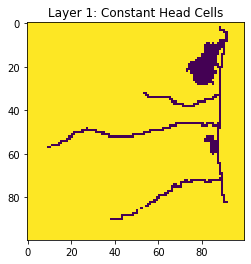

In [220]:
# vizualize the BC cells
iper = 0
ibd = np.ones((nlay, nrow, ncol), dtype=np.int)

ra = chd.stress_period_data.get_data(key=iper)
rb = Riv1.stress_period_data.get_data(key=iper)
rc = Riv2.stress_period_data.get_data(key=iper)
#rd = Riv3.stress_period_data.get_data(key=iper)
re = etangs.stress_period_data.get_data(key=iper)
rf = Riv4.stress_period_data.get_data(key=iper)

for k, i, j in ra['cellid']:
    ibd[k, i, j] = -1
    
for k, i, j in rb['cellid']:
    ibd[k, i, j] = -1

for k, i, j in rc['cellid']:
    ibd[k, i, j] = -1

#for k, i, j in rd['cellid']:
#    ibd[k, i, j] = -1

for k, i, j in re['cellid']:
    ibd[k, i, j] = -1

for k, i, j in rf['cellid']:
    ibd[k, i, j] = -1

ilay = 0
plt.imshow(ibd[ilay, :, :], interpolation='none')
plt.title('Layer {}: Constant Head Cells'.format(ilay + 1))

In [221]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model first_2D...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package oc...
    writing package sea...
    writing package eta...
    writing package agy...
    writing package tet...
    writing package tech...


In [222]:
sim.run_simulation()

FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Soft

(True, [])

In [223]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

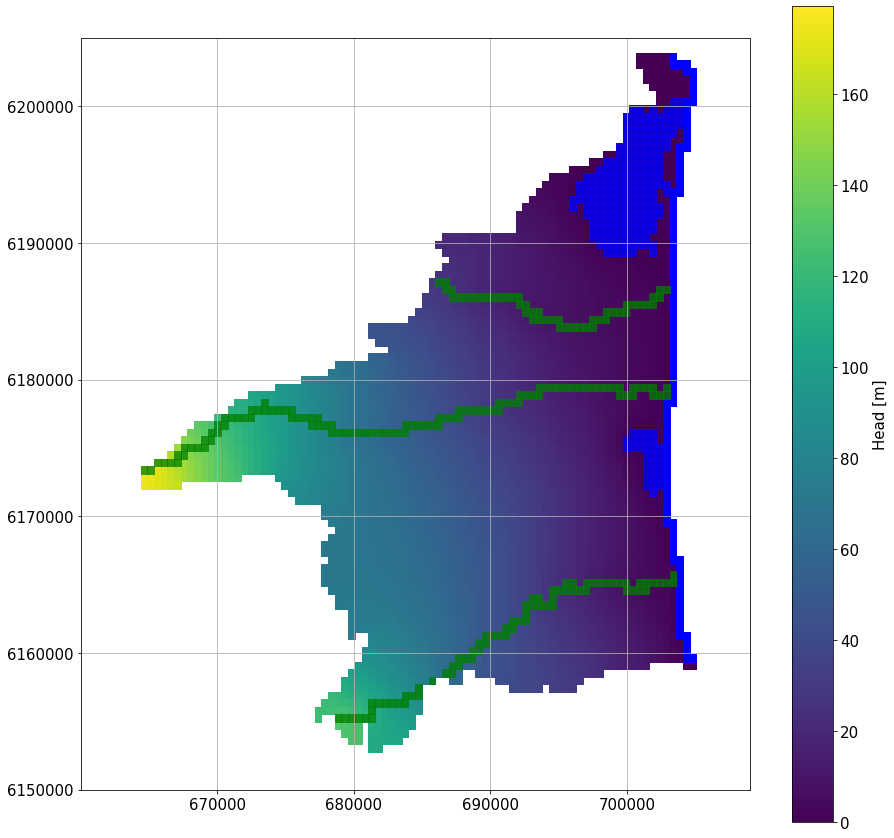

In [235]:
# make a plot
fig = plt.figure(figsize=(15,15))
ax  = plt.subplot(1, 1, 1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

#hmesh=ml.plot_ibound()
hmesh=ml.plot_array(head,masked_values=[1e30],cmap="viridis")

#ml.plot_specific_discharge(spdis[0],color="w",width=0.0030)
ml.plot_bc("sea",color="b")
ml.plot_bc("Tet",color="g",alpha=0.5)
ml.plot_bc("Agy",color="g",alpha=0.5)
ml.plot_bc("Tech",color="g",alpha=0.5)
ml.plot_bc("eta",color="b",alpha=0.5)
ax.tick_params(labelsize=15)
#ax.tick_params(axis="y",direction="in", pad=-120)

g = plt.colorbar(hmesh)

g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)


plt.grid()

In [225]:
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

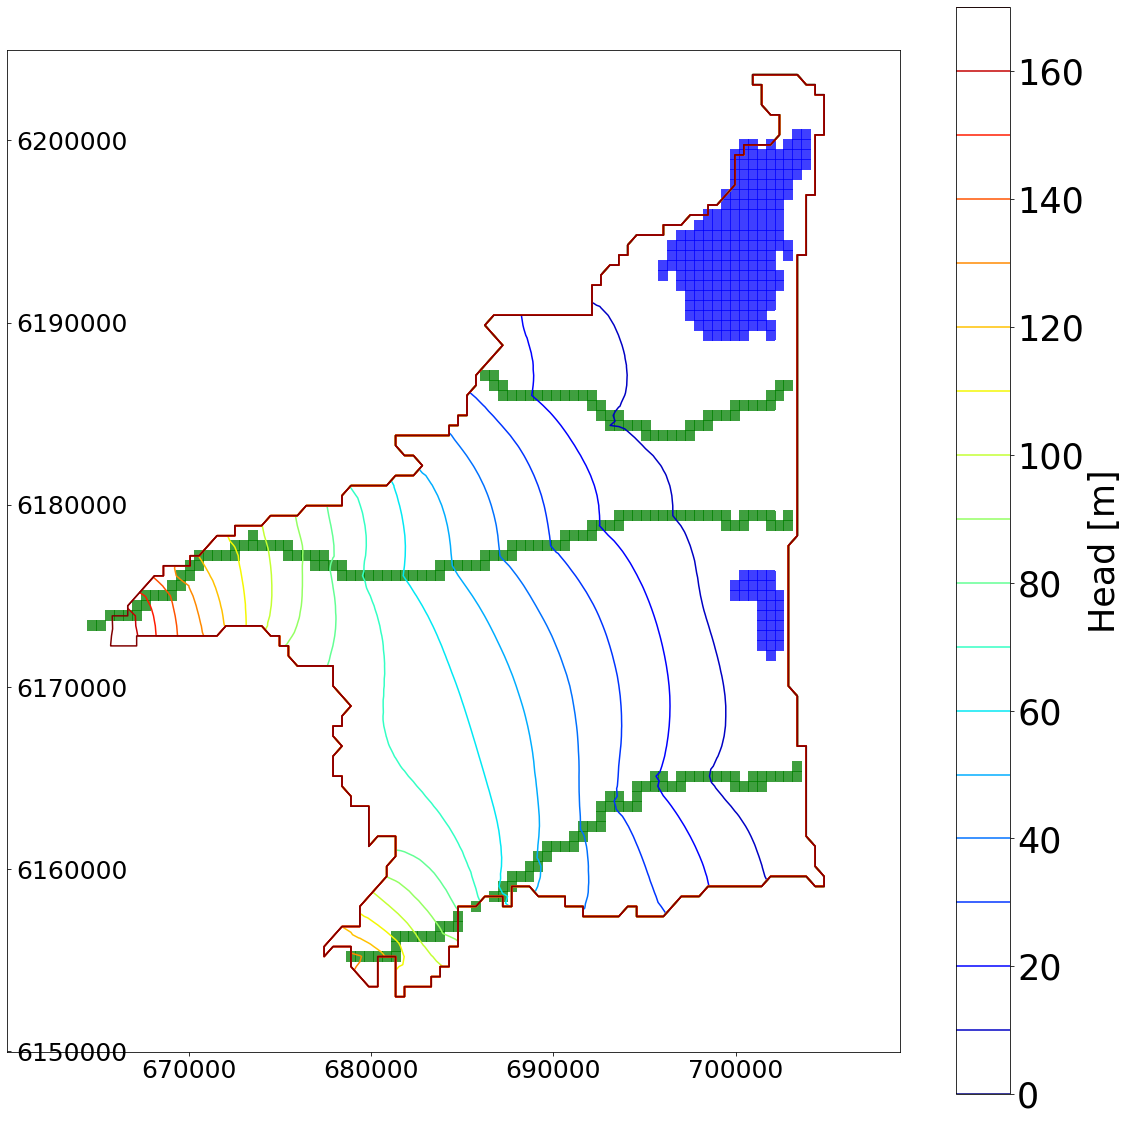

In [226]:
fig = plt.figure(figsize=(20,20))
ax  = plt.subplot(1, 1, 1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

hmesh=ml.contour_array(head,levels=np.linspace(0,170,18),cmap="jet")

ml.plot_bc("Tet",color="g",alpha=0.5)
ml.plot_bc("Agy",color="g",alpha=0.5)
ml.plot_bc("Tech",color="g",alpha=0.5)
#ml.plot_bc("Rea",color="g",alpha=0.5)
ml.plot_bc("eta",color="b",alpha=0.5)

g=plt.colorbar(hmesh)
g.ax.tick_params(labelsize=35)
g.set_label("Head [m]",fontsize=35)
ax.tick_params(labelsize=25)
ax.tick_params(axis="y",direction="in", pad=-120)

In [227]:
# Total Budget
lstBudgetfile = "{}.lst".format(model_name)
fname = os.path.join(model_dir,lstBudgetfile)
Budgetobj = fp.utils.Mf6ListBudget(fname)

In [228]:
for i in Budgetobj.entries:
    if i != "PERCENT_DISCREPANCY":
        print("{} : {} m3/s".format(i,Budgetobj.get_budget(names=i)[0][0][-1]))

RCH_IN : 2.894399881362915 m3/s
CHD_IN : 2.494499921798706 m3/s
TOTAL_IN : 8.49470043182373 m3/s
RCH_OUT : 0.0 m3/s
CHD_OUT : 2.750499963760376 m3/s
TOTAL_OUT : 8.49470043182373 m3/s
IN-OUT : -3.627900150604546e-05 m3/s


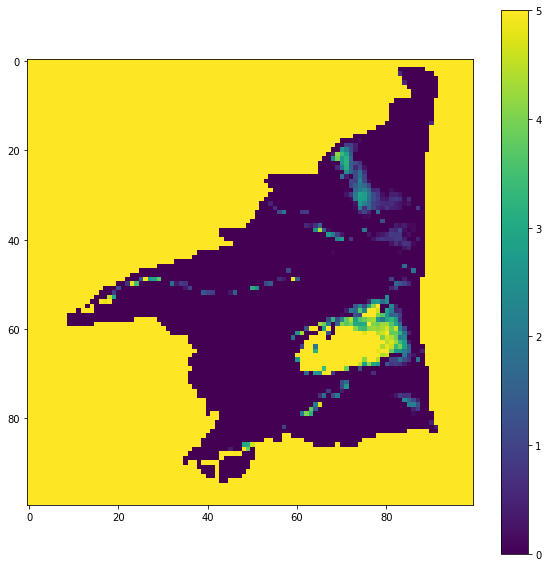

In [236]:
plt.figure(figsize=(10,10))
a=plt.imshow(head[0]-top)
plt.colorbar()
a.set_clim(0,5)